We want to look at filters acting on surfaces. The prinicple is the same as those acting on 1D or 3D data. But I especially want to revisit and extend an article I wrote several years ago on smoothing surfaces — Hall, M (2007). Smooth operator: smoothing seismic horizons and attributes. I didn't realize it at the time, but that article had some deficiencies:

- It used proprietary data
- It used proprietary software (Landmark's PowerCalculator tool)
- Though I offered to share my scripts, they were not readily available
- It was published under SEG's copyright and a closed license

In this IPython Notebook, I will fix some of these problems. Open data, open software, all on the web, and all CC-BY-SA. I hope you find it interesting and/or useful.

Here's the plan of attack:

- Read some data
- Build a kernel (the filter pattern)
- Run the kernel over the data; there are a couple of ways of doing this
- Look at the output and compare to the input

# Exporting some data

First, we'll find our data in OpendTect. We will use the open-access Penobscot dataset from offshore Nova Scotia, quite near my house. This is a great dataset for lots of reasons, but especially because it is freely available and can be shared in almost any way you like. You can download it from the [Open Seismic Repository](https://opendtect.org/osr/). The data is owned by the Nova Scotia Deptartment of Energy and licensed [CC-BY](http://bit.ly/cc-by). I used OpendTect software to load the data, then export one of the horizons that comes with the data, a shallow horizon called Horizon B. I exported the whole thing as an inline,crossline (as opposed to x,y) ASCII file.

Reading data
============

Using NumPy, we can easily read the data into a Python variable called <code>data</code>. NumPy is just a Python library (a bunch of commands, basically) that makes mathematics on big datasets faster. We could use Python's standard tools, but why make things more difficult for ourselves? To use a library like NumPy, we have to import it first.

In [4]:
import numpy
data = numpy.loadtxt('Penobscot_HorB.txt')
print (data[:10])

[[1003.         1010.          926.39195919]
 [1003.         1011.          925.13644695]
 [1003.         1012.          924.19928312]
 [1003.         1013.          923.78389835]
 [1003.         1014.          923.74902964]
 [1003.         1015.          923.5907793 ]
 [1003.         1016.          923.72643948]
 [1003.         1017.          923.48623276]
 [1003.         1018.          923.40993881]
 [1003.         1019.          922.38986492]]


The square bracket notation is called a 'slice'; it gives us the first 10 rows of <code>data</code>. Slicing, and the closely related indexing action, are very useful — and you'll see them a lot in Python code.

As expected, we have inline, xline, and two-way time.

Notice that we only exported values where there is data — inlines 1003 to 1597, and xlines 1009 to 1471. We know from OpendTect that the extents of the survey data are: inlines 1000 to 1600, and xlines 1000 to 1481... so null samples were omitted and we need the inline and xline values (aside: otherwise we could just take the third column and reshape it). Also notice that the first row in our dataset is near the lower-left corner of the survey. 

To keep things easy later on, we'll use the extents of the horizon from the OpendTect export dialog (above), and preserve this shape. 

In [9]:
inlines = 1597 - 1003 + 1
xlines = 1471 - 1009 + 1

print (inlines, 'inlines')
print (xlines, 'crosslines')

595 inlines
463 crosslines


So we'll want a data object — an array — that has 595 rows and 463 columns. We'll make that in a minute. 

Mapping our data into that array will be much easier if we convert those inlines and crosslines to 'coordinates', called indices, in the array. We can use slicing to do math on the first column — called <code>data[:,0]</code>. This means 'all rows, first column (which has index 0).

In [10]:
data[:,0] = inlines - (data[:,0] - 1002) 
data[:,1] -= 1008 # same as data[:,1] = data[:,1] - 1008

data[:5]

array([[594.        ,   2.        , 926.39195919],
       [594.        ,   3.        , 925.13644695],
       [594.        ,   4.        , 924.19928312],
       [594.        ,   5.        , 923.78389835],
       [594.        ,   6.        , 923.74902964]])

Now we can make an empty array to hold our data:

In [11]:
horizon = numpy.empty((inlines, xlines))
print (horizon)
print (horizon.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(595, 463)


Now we can cast the list we made into the array.

In [13]:
for sample in data:
    inline = int(sample[0])
    xline = int(sample[1])
    z_value = sample[2]
    
    # We have to subtract 1 to allow for 0-based indexing
    horizon[inline - 1, xline - 1] = z_value

horizon

array([[   0.        ,    0.        ,    0.        , ..., 1088.39404583,
        1088.08231354, 1087.8816843 ],
       [   0.        ,    0.        ,    0.        , ..., 1088.29820156,
        1087.96453476, 1087.78274059],
       [   0.        ,    0.        ,    0.        , ..., 1088.17863464,
        1087.8431797 , 1087.68224716],
       ...,
       [   0.        ,  926.46729946,  925.56166649, ...,  972.23240137,
         972.9629159 ,  974.19649363],
       [   0.        ,  926.39195919,  925.13644695, ...,  973.05631638,
         973.32763672,  974.58219528],
       [   0.        ,    0.        ,    0.        , ..., 1088.48810196,
        1088.18411827, 1087.98325062]])

Notice that NumPy conveniently summarizes the array, so we don't get lines and lines of data. Let's check that its dimensions look OK:

In [15]:
print ("Rows and columns: {0}".format(horizon.shape))
print ("Number of elements: {0}".format(inlines * xlines))

Rows and columns: (595, 463)
Number of elements: 275485


Plotting data
=============
One of the most powerful things about the PyLab environment is the easy plotting. First, we declare that we want plots 'inline' (in this IPython Notebook, as opposed to in their own windows). The we need to import some libraries:

In [18]:
import matplotlib.pyplot as plt

Now we can issue some plot commands. We set up a 'figure', then define what goes into it — at least some data — and then show it. It's super-easy...

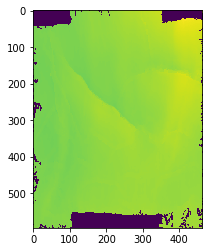

In [19]:
plt.imshow(horizon)
plt.show()

Okay, not that easy. There are some problems here:

- It's the wrong shape, because the seismic bins aren't square — we can fix this by setting an aspect ratio
- There's no colourbar — we can add one with <code>plt.colorbar()</code>
- There's not much dynamic range, probably because the nulls are included in the colour range

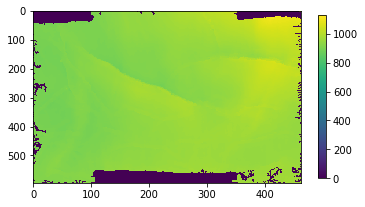

In [20]:
plt.imshow(horizon, aspect=0.5)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

This colourmap is no good, [rainbows are bad for you](http://mycarta.wordpress.com/2012/05/12/the-rainbow-is-dead-long-live-the-rainbow-part-1/). We can switch to a more brain-friendly one called [cubehelix](http://www.mrao.cam.ac.uk/~dag/CUBEHELIX/) (Green, D. A. (2011). A colour scheme for the display of astronomical intensity images. *Bulletin of the Astromical Society of India* **39**, p 289-295. [2011BASI...39..289G](http://adsabs.harvard.edu/abs/2011BASI...39..289G) and [arXiv:1108.5083](http://arxiv.org/abs/1108.5083)) and - reverse it by adding <code>_r</code> to the name. We'll set that colourbar as the default:

In [21]:
plt.set_cmap('cubehelix_r')

<Figure size 432x288 with 0 Axes>

As we suspected, the null values are skewing the colourbar. Let's use <code>numpy.percentile</code> to find good values for the min and max. A clever trick lets us exclude datapoints that are zero (or less). 

In [22]:
vmin = numpy.percentile(horizon[horizon > 0], 1)
vmax = numpy.percentile(horizon[horizon > 0], 99)
print ('min {0}, max {1}'.format(vmin, vmax))

min 891.804814338684, max 1065.9542727470366


Now we can use these vmin and vmax variables in our plots, so we get nice colours.

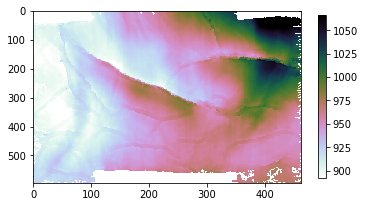

In [23]:
plt.imshow(horizon, aspect=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

These plots aren't interactive, but we can pick an area to replot at a larger scale...

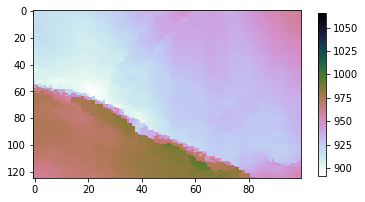

In [24]:
plt.imshow(horizon[200:325,200:300], aspect=0.5, vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.75)  # shrink makes the colourbar a bit shorter
plt.show()

Let's show where that is on the main map — I hope there's a better way to do this, but I'll just draw a bunch of lines... 

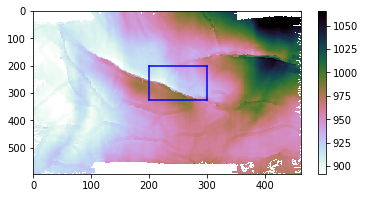

In [25]:
plt.figure(figsize=(6,3)) # aspect can't cope with the plot overlays
plt.imshow(horizon, vmin=vmin, vmax=vmax)
plt.plot([200,300], [200,200], 'b')
plt.plot([200,300], [325,325], 'b')
plt.plot([200,200], [200,325], 'b')
plt.plot([300,300], [200,325], 'b')
plt.colorbar()
plt.axis('tight') # makes the plot overlay behave
plt.show()

Adding noise
============
This horizon has some edges, which is nice, but it's rather smooth in between the edges. We'd really like to add some noise. the <code>numpy.random</code> library has lots of distributions (Poisson, beta, etc), but we'll just go with a continuous uniform distiubtion, scaled to 100 (otherwise it would be distributed from 0 to 1 ms):

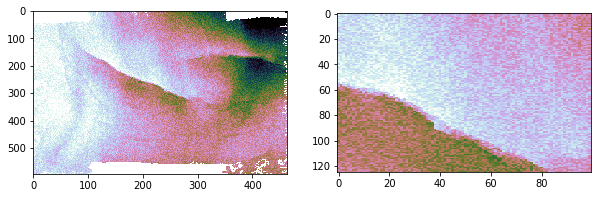

In [27]:
noise = numpy.random.uniform(-15,15, horizon.shape)
noisy_horizon = horizon + noise

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(noisy_horizon, aspect=0.5, vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(noisy_horizon[200:325,200:300], aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

Let's look at a 'cross-section' of the horizons together. We'll use slicing to avoid the last few xlines, which have null values and skew the y-axis:

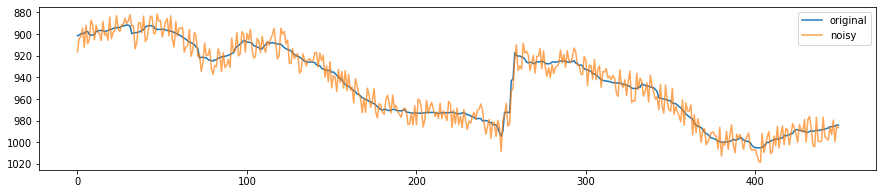

In [28]:
plt.figure(figsize=(15,3))
plt.plot(horizon[300,:450])
plt.plot(noisy_horizon[300,:450], alpha=0.7) # reduce the opacity a bit with alpha
plt.legend(('original', 'noisy'))
plt.gca().invert_yaxis()  # show two-way time increasing downwards
plt.show()

What is convolution?
====================
Convolution is an algorithm: a stepwise process with some input and some transformed or generated output. Let's look at a 1D example. We'll convolve a simple pair of numbers, which you can think of as two spikes, with a special function that smoothes spikes out (a filter):

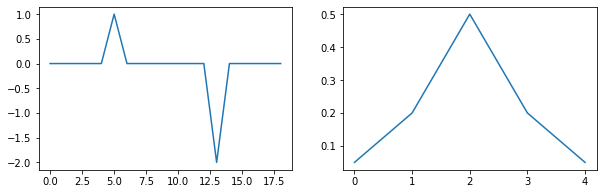

In [31]:
import numpy
my_spikes = numpy.zeros(19)
my_spikes[5] = 1
my_spikes[13] = -2

my_filter = numpy.array([0.05, 0.2, 0.5, 0.2, 0.05])

x = numpy.arange(len(my_spikes)) # for the plot

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(my_spikes)
plt.subplot(1,2,2)
plt.plot(my_filter)
plt.show()

Now we can do the convolution. It happens one step at a time. At each step, we multiply the spiky array by the filter, and sum the results. Notice that to evaluate the first element in the array, we'll either need to pad with zeros, or cut off the first two elements. We'll cut them off. 

[ 0.    0.05  0.2   0.5   0.2   0.05  0.    0.    0.   -0.1  -0.4  -1.
 -0.4  -0.1   0.  ]


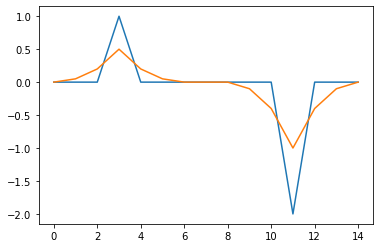

In [33]:
result = numpy.zeros_like(my_spikes[2:-2])  # Copy the 3 to the (n-2)th elements of the array
for i in numpy.arange(len(result)):
    for j in numpy.arange(len(my_filter)):
        result[i] += my_spikes[(i + 2) +  (j - 2)] * my_filter[j]

print (result)

plt.plot(my_spikes[2:-2])
plt.plot(result)
plt.show()

The result is essentially just the sum of the kernels, scaled by the spikes. 

Building a kernel
=================
Before we can do any work on a horizon, which is a 2D array, we need a 2D kernel. This is the name for the tile, or convolutional operator, we will run over the surface to change it. We will start with the simplest filter: a 3 &times; 3 mean filter. All we need is an array of 1s, which we divide by 9 for the mean.

In [35]:
kernel = numpy.ones((3,3)) / 9
print (kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


A visualization of the kernel is, of course, rather boring:

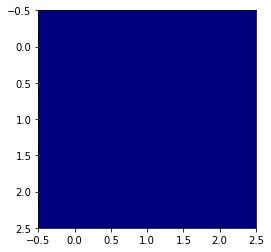

In [36]:
plt.imshow(kernel, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.show()

Smooth the data & inspect the output
===============
To  use the filter, we run it over the surface, one sample at a time. We simply sum the product of the values in the kernel with those in the surface. We'll have to use a nested loop to run across the columns, then down the rows, 'reading' the input with our 'viewfinder' kernel, and 'writing' the output like a book. We'll do some plus and minus 1 and 2 here and there to keep away from the edges. Hmmm, sounds complicated, maybe it's easier to do than to explain:

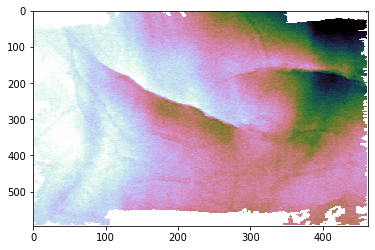

In [37]:
# make an empty array the same shape as the input
output = numpy.empty_like(horizon) 

for x in range(inlines - 2):
    for y in range(xlines - 2):
        sum_at_this_stop = 0
        for i in range(3):
            for j in range(3):
                horizon_value = noisy_horizon[(x+1)+(i-1),(y+1)+(j-1)]
                kernel_value = kernel[i,j]
                sum_at_this_stop += kernel_value * horizon_value
        output[x+1,y+1] = sum_at_this_stop

plt.imshow(output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

To make this tolerate different kernel sizes, we'd want to change the hard-coded offsets (e.g. <code>inlines - 2</code> and <code>horizon(x+1)</code> — I'm keeping away from the edges) and <code>range(3)</code>. The numbers are based on the dimensions of <code>kernel</code>, which we get at using its <code>shape</code> parameter (note the way integers divide here):

In [39]:
print (kernel.shape)

inline_offset = kernel.shape[1]/2 # this is modulo division, the deault for integers
xline_offset = kernel.shape[0]/2
print(inline_offset, xline_offset)

(3, 3)
1.5 1.5


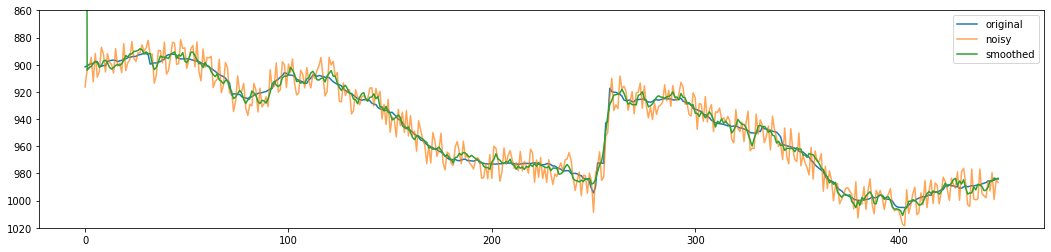

In [40]:
plt.figure(figsize=(18,4))
plt.plot(horizon[300,:450])
plt.plot(noisy_horizon[300,:450], alpha=0.7)
plt.plot(output[300,:450])
plt.ylim((860,1020))
plt.legend(('original', 'noisy', 'smoothed'))
plt.gca().invert_yaxis()
plt.savefig('Smoothing_result_new.png')
plt.show()

It did very well, but did 'erode' the top and bottom of the fault a bit. 

Get faster
==========
If this seems a bit, er, complicated, fear not. We don't really have to go through all this. We can just use the extensive SciPy library. NumPy gives us all the *n*-dimensional array goodness, but SciPy brings the fast Fourier transforms, interpolation, linear algebra, statistics, and signal processing. So compare the crazy nested loop thing above to this:

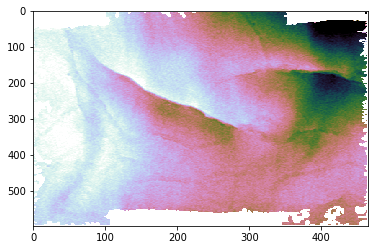

In [41]:
import scipy.signal
new_output = scipy.signal.convolve2d(noisy_horizon, kernel)

plt.imshow(new_output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

There's yet another way to do convolution. A convolution is equivalent to a multiplication of Fourier coefficients. So we can take Fourier transforms of the kernel and the horizon, multiply them, and take the inverse Fourier transform to get our result... but this would be horrible to implement (because of various limitations of the fast Fourier transform) so let's just use the builtin

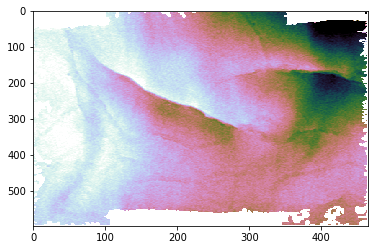

In [42]:
fft_output = scipy.signal.fftconvolve(noisy_horizon, kernel)

plt.imshow(fft_output, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

If you're really concerned about speed, there's an easy way to time things:

In [43]:
%timeit new_output = scipy.signal.convolve2d(noisy_horizon, kernel)
%timeit fft_output = scipy.signal.fftconvolve(noisy_horizon, kernel)

29.2 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.1 ms ± 522 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Surprisingly, convolve2d is over 25% faster than fftconvolve in this case (on this data, on my machine, etc). 

More kernels
============
Convolution is a wonderful thing. I find the smoothing trick easy to understand intuitiveily — we're mixing the samples in a neighbourhood at each pixel. It's easy to see how this blurs, or smooths, the image. But look at these filters, all of a kind, and see if you can guess what they do (or maybe you recognize their names?)... 

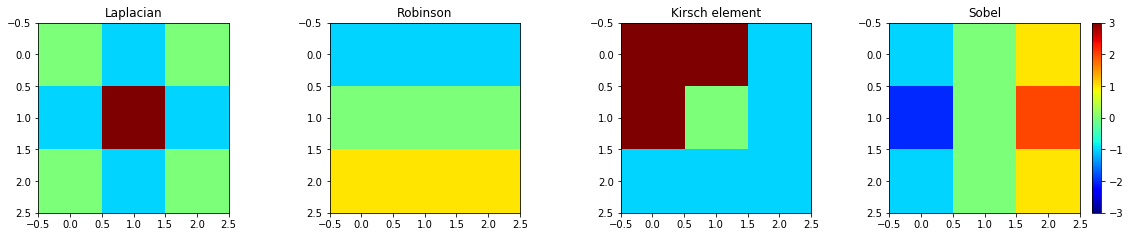

In [44]:
laplacian = numpy.array([[0, -1,  0],
                         [-1,  4,  -1],
                         [0, -1,  0]])

robinson = numpy.array([[-1, -1, -1],
                        [ 0,  0,  0],
                        [ 1,  1,  1]])

kirsch = numpy.array([[ 3,   3,  -1],
                      [ 3,   0,  -1],
                      [-1,  -1,  -1]])

sobel = numpy.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

plt.figure(figsize=(20,3.5))
plt.subplot(1,4,1)
plt.imshow(laplacian, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Laplacian')
plt.subplot(1,4,2)
plt.imshow(robinson, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Robinson')
plt.subplot(1,4,3)
plt.imshow(kirsch, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Kirsch element')
plt.subplot(1,4,4)
plt.imshow(sobel, cmap=plt.get_cmap('jet'), interpolation='nearest', vmin=-3, vmax=3)
plt.title('Sobel')
plt.colorbar(ticks=[-3, -2, -1, 0, 1, 2, 3])
plt.show()

Sidenote: this is not how you would actually use the Kirsch filter. The filter works by selecting the maximum value from each of the results obtained by rotating the kernel — [read more on Wikipedia](https://en.wikipedia.org/wiki/Kirsch_operator).

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


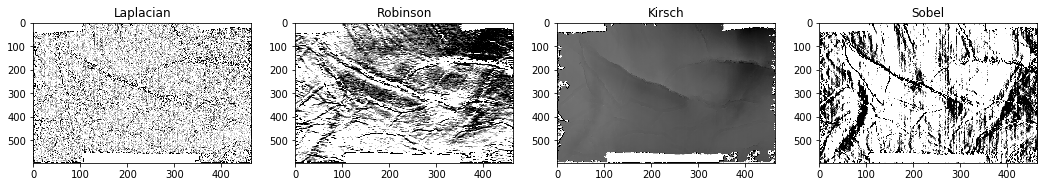

In [46]:
shaded_relief = scipy.signal.convolve2d(horizon, laplacian)
robinson_relief = scipy.signal.convolve2d(horizon, robinson)
kirsch_element = scipy.signal.convolve2d(horizon, kirsch)
sobel_relief = scipy.signal.convolve2d(horizon, sobel)

plt.figure(figsize=(18,3))
plt.subplot(1,4,1)
plt.imshow(shaded_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Laplacian')
plt.subplot(1,4,2)
plt.imshow(robinson_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Robinson')
plt.subplot(1,4,3)
plt.imshow(kirsch_element**2, cmap=plt.get_cmap('Greys'), vmax=20000000, aspect=0.5)
plt.title('Kirsch')
plt.subplot(1,4,4)
plt.imshow(sobel_relief**0.5, cmap=plt.get_cmap('Greys'), vmax=2, aspect=0.5)
plt.title('Sobel')
plt.show()

The <code>scipy.signal</code> library contains lots of other filters. A median filter — one of the most popular non-linear edge-preserving filters, is ready to use:

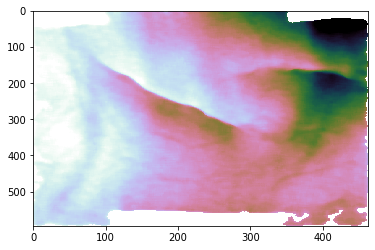

In [47]:
median = scipy.signal.medfilt2d(noisy_horizon,11)

plt.imshow(median, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

Likewise, a Gaussian filter is easy to implement, using a related library, <code>ndimage</code> (n-dimensional image processing). The second parameter is the standard deviation, which controls how smooth the output is.

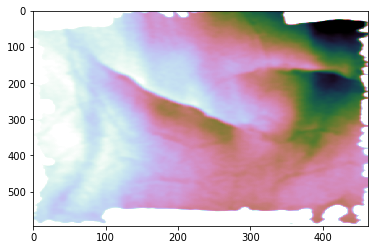

In [48]:
import scipy.ndimage
gaussian = scipy.ndimage.filters.gaussian_filter(noisy_horizon, 3.0)

plt.imshow(gaussian, aspect=0.5, vmin=vmin, vmax=vmax)
plt.show()

Or we can make a Gaussian kernel, if we want to look at it. I've plotted it without interpolation, so you can see the 11 &times; 11 matrix:

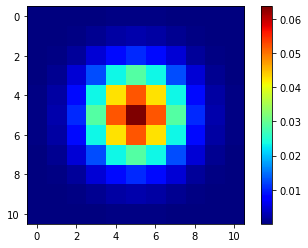

In [49]:
def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = numpy.mgrid[-size:size+1, -size_y:size_y+1]
    g = numpy.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(5)

plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()

Final analysis
==============
All of the filters seem to deal well with the random noise. Bearing in mind that we deliberately made the Gaussian filter rather aggressive compared to the others, let's compare how they all do around that fault...

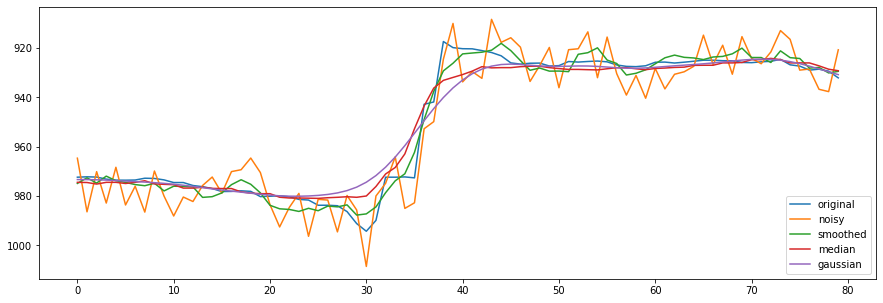

In [50]:
plt.figure(figsize=(15,5))
plt.plot(horizon[300,220:300])
plt.plot(noisy_horizon[300,220:300])
plt.plot(output[300,220:300])
plt.plot(median[300,220:300])
plt.plot(gaussian[300,220:300])
plt.legend(('original', 'noisy', 'smoothed', 'median', 'gaussian'), loc=4)
plt.gca().invert_yaxis()
plt.show()

As expected, the median filter does a very good job of respecting the fault, while eliminating the random noise. 